In [2]:
import pandas as pd

In [4]:
df = pd.read_csv('B3DB_classification.tsv', sep='\t')

In [6]:
df.head()

,NO.,compound_name,IUPAC_name,SMILES,CID,logBB,BBB+/BBB-,Inchi,threshold,reference,group,comments
0,1,sulphasalazine,2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,5339.0,-2.69,BBB-,InChI=1S/C18H14N4O5S/c23-16-9-6-13(11-15(16)18...,NaN,R2|R2|R25|R46|,A,NaN
1,2,moxalactam,7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,3889.0,-2.52,BBB-,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,NaN,R25|,A,NaN
2,3,clioquinol,5-chloro-7-iodoquinolin-8-ol,Oc1c(I)cc(Cl)c2cccnc12,2788.0,-2.40,BBB-,InChI=1S/C9H5ClINO/c10-6-4-7(11)9(13)8-5(6)2-1...,NaN,R18|R26|R27|,A,NaN
3,4,bbcpd11 (cimetidine analog) (y-g13),2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...,CCNC(=NCCSCc1ncccc1Br)NC#N,14022517.0,-2.15,BBB-,InChI=1S/C12H16BrN5S/c1-2-15-12(18-9-14)17-6-7...,NaN,R2|R2|R8|R40|R2|R2|R2|R2|R18|R21|R25|R25|R26|R...,A,NaN
4,5,schembl614298,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...",CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,18595497.0,-2.15,BBB-,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...,NaN,R25|,A,NaN


In [8]:
df['label'] = df['BBB+/BBB-'].map({'BBB+': 1, 'BBB-': 0})

In [10]:
df = df[['SMILES', 'label']]  

In [12]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

C:\Users\vivek\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
df = df[["SMILES", "label"]] 

In [81]:
# Tokenize the SMILES using ChemBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

def tokenize(batch):
    return tokenizer(batch["SMILES"], padding="max_length", truncation=True, max_length=128)

dataset = Dataset.from_pandas(df)
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.train_test_split(test_size=0.2)

Map: 100%|█████████████████████████████████████████████████████████████████████████████| 7807/7807 [00:01<00:00, 7438.54 examples/s]


In [83]:
# Load ChemBERTa with classification head (binary)
model = AutoModelForSequenceClassification.from_pretrained(
    "seyonec/ChemBERTa-zinc-base-v1",
    num_labels=2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "auc": roc_auc_score(labels, p.predictions[:, 1])
    }

In [87]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./test-output",
    eval_strategy="epoch",  
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=10
)

print("TrainingArguments created successfully.")

TrainingArguments created successfully.


In [89]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

C:\Users\vivek\AppData\Local\Temp\ipykernel_4800\249616725.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\vivek\anaconda3\envs\pytorch-env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,0.474200,0.381824,0.853393,0.889425,0.916327


TrainOutput(global_step=781, training_loss=0.4051310898552478, metrics={'train_runtime': 6625.3117, 'train_samples_per_second': 0.943, 'train_steps_per_second': 0.118, 'total_flos': 206814726151680.0, 'train_loss': 0.4051310898552478, 'epoch': 1.0})

In [92]:
def predict_smiles(smiles_str):
    model.eval()
    inputs = tokenizer(smiles_str, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()
    return prediction, probs.squeeze().tolist()

smiles = "CCO"
predict_smiles(smiles)

(1, [0.06468452513217926, 0.9353154897689819])

In [94]:
from transformers import AutoTokenizer

model.save_pretrained("my_saved_model/")
tokenizer.save_pretrained("my_saved_model/")

('my_saved_model/tokenizer_config.json',
 'my_saved_model/special_tokens_map.json',
 'my_saved_model/vocab.json',
 'my_saved_model/merges.txt',
 'my_saved_model/added_tokens.json',
 'my_saved_model/tokenizer.json')

In [96]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained("my_saved_model/")
tokenizer = AutoTokenizer.from_pretrained("my_saved_model/")

smiles = "CNC(=O)C1=CC=C(C=C1)S(=O)(=O)N"  # Sulfonamide 
inputs = tokenizer(smiles, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()

print("Prediction:", prediction)

Prediction: 1


In [100]:
logits = model(**inputs).logits
probs = torch.softmax(logits, dim=1).detach().numpy()
predicted_class = np.argmax(probs, axis=1)

In [102]:
probs

array([[0.03830663, 0.96169335]], dtype=float32)

In [104]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained("my_saved_model/")
tokenizer = AutoTokenizer.from_pretrained("my_saved_model/")
model.eval()  

smiles_list = [
    # Known permeable
    "CCO",                                       # Ethanol (permeable, small & lipophilic) [Pardridge, 2012]
    "CC(=O)O",                                   # Acetic acid (permeable) [Pardridge, 2012]
    "c1ccccc1",                                  # Benzene (permeable) [Oldendorf, 1971]
    "C1[C@H]2[C@H](CN1)OC3=C(O2)C=CC=C3F",       # Fluparoxan (permeable α2 antagonist) [Hudson et al., 2005]
    "CN1CCC(CC1)C2=CC=CC=C2O",                   # Serotonin (permeable but actively transported) [Pardridge, 1998]
    "CC(C)NCCC1=CC2=C(C=C1)OCO2",                # Donepezil (permeable, Alzheimer's drug) [Sugimoto et al., 2000]
    
    # Known NON-permeable
    "C(C(=O)O)N",                                # Glycine (polar amino acid, poor passive BBB penetration) [Pardridge, 1977]
    "C1=CC(=CC=C1C(=O)O)O",                      # Salicylic acid (polar, low BBB penetration) [Banks, 2009]
    "C1=CC(=CC=C1C(=O)O)C(=O)O",                 # Phthalic acid (very polar, non-permeable) [Banks, 2009]
    "C1=CC(=CC=C1O)O",                           # Catechol (hydrophilic, low BBB penetration) [Pardridge, 1998]
    "NC(=O)C(CC(=O)O)N",   

]
        
inputs = tokenizer(
    smiles_list,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)

for smile, pred, prob in zip(smiles_list, preds.tolist(), probs.tolist()):
    print(f"SMILES: {smile}")
    print(f"  → Predicted class: {pred} (Prob: {prob[pred]:.4f})\n")

SMILES: CCO
  → Predicted class: 1 (Prob: 0.9353)

SMILES: CC(=O)O
  → Predicted class: 1 (Prob: 0.5253)

SMILES: c1ccccc1
  → Predicted class: 1 (Prob: 0.9707)

SMILES: C1[C@H]2[C@H](CN1)OC3=C(O2)C=CC=C3F
  → Predicted class: 1 (Prob: 0.9907)

SMILES: CN1CCC(CC1)C2=CC=CC=C2O
  → Predicted class: 1 (Prob: 0.9113)

SMILES: CC(C)NCCC1=CC2=C(C=C1)OCO2
  → Predicted class: 1 (Prob: 0.9197)

SMILES: C(C(=O)O)N
  → Predicted class: 1 (Prob: 0.6692)

SMILES: C1=CC(=CC=C1C(=O)O)O
  → Predicted class: 0 (Prob: 0.5474)

SMILES: C1=CC(=CC=C1C(=O)O)C(=O)O
  → Predicted class: 0 (Prob: 0.6309)

SMILES: C1=CC(=CC=C1O)O
  → Predicted class: 1 (Prob: 0.8711)

SMILES: NC(=O)C(CC(=O)O)N
  → Predicted class: 1 (Prob: 0.6256)



##  Generating embeddings

In [20]:
df.head(1)

,SMILES,label
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,0


In [22]:
smiles_list = df['SMILES'].tolist()

labels = df['label'].values

In [24]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader

tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chemberta = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chemberta.eval()  # Freeze weights

def get_chemberta_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = chemberta(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # [CLS] token

In [25]:
embeddings = np.array([get_chemberta_embedding(smi) for smi in smiles_list])

In [28]:
embeddings 

array([[ 0.25248706,  0.44628125,  0.04109137, ..., -1.660102  ,
        -0.41999194,  0.5287114 ],
       [ 1.1333145 , -0.29413953, -0.77996933, ..., -0.4390333 ,
         0.18617637,  1.1964507 ],
       [ 2.115616  ,  0.4459534 ,  0.99493134, ..., -0.6753521 ,
        -1.0299244 ,  2.400854  ],
       ...,
       [ 2.2383883 ,  0.7994697 , -0.21661702, ...,  0.41989818,
        -0.29922205,  1.134143  ],
       [ 2.0040555 , -0.40020815,  0.05821397, ..., -0.77413154,
        -0.8853831 ,  0.0230846 ],
       [ 1.3414127 , -1.132047  , -0.5651429 , ..., -0.17915855,
        -1.2964383 ,  1.318701  ]], shape=(7807, 768), dtype=float32)

In [30]:
class MoleculeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

train_dataset = MoleculeDataset(X_train, y_train)
test_dataset = MoleculeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
import torch.nn as nn

class ChemBERTaClassifier(nn.Module):
    def __init__(self, input_dim=768):
        super(ChemBERTaClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2)  # binary classification
        )

    def forward(self, x):
        return self.net(x)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ChemBERTaClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 98.2621
Epoch 2, Loss: 81.3928
Epoch 3, Loss: 75.0916
Epoch 4, Loss: 69.4266
Epoch 5, Loss: 64.5297
Epoch 6, Loss: 60.2866
Epoch 7, Loss: 56.6024
Epoch 8, Loss: 53.6189
Epoch 9, Loss: 50.2984
Epoch 10, Loss: 46.3834
Epoch 11, Loss: 42.2818
Epoch 12, Loss: 41.0620
Epoch 13, Loss: 38.8868
Epoch 14, Loss: 34.6481
Epoch 15, Loss: 33.6919
Epoch 16, Loss: 31.3513
Epoch 17, Loss: 29.4023
Epoch 18, Loss: 27.5053
Epoch 19, Loss: 25.1107
Epoch 20, Loss: 24.3870
Epoch 21, Loss: 22.3992
Epoch 22, Loss: 20.6066
Epoch 23, Loss: 18.7971
Epoch 24, Loss: 18.7385
Epoch 25, Loss: 17.4708
Epoch 26, Loss: 16.6806
Epoch 27, Loss: 15.4447
Epoch 28, Loss: 17.2860
Epoch 29, Loss: 14.6990
Epoch 30, Loss: 16.1399
Epoch 31, Loss: 14.8007
Epoch 32, Loss: 16.9992
Epoch 33, Loss: 15.2555
Epoch 34, Loss: 13.0721
Epoch 35, Loss: 13.2279
Epoch 36, Loss: 11.8983
Epoch 37, Loss: 13.6041
Epoch 38, Loss: 12.4453
Epoch 39, Loss: 12.0237
Epoch 40, Loss: 10.9727
Epoch 41, Loss: 12.0418
Epoch 42, Loss: 11.7246
E

In [35]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(y_batch.numpy())

print(classification_report(all_true, all_preds))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       561
           1       0.88      0.89      0.89      1001

    accuracy                           0.85      1562
   macro avg       0.84      0.84      0.84      1562
weighted avg       0.85      0.85      0.85      1562



              precision    recall  f1-score   support

           0       0.80      0.78      0.79       561
           1       0.88      0.89      0.89      1001

    accuracy                           0.85      1562
   macro avg       0.84      0.84      0.84      1562
weighted avg       0.85      0.85      0.85      1562



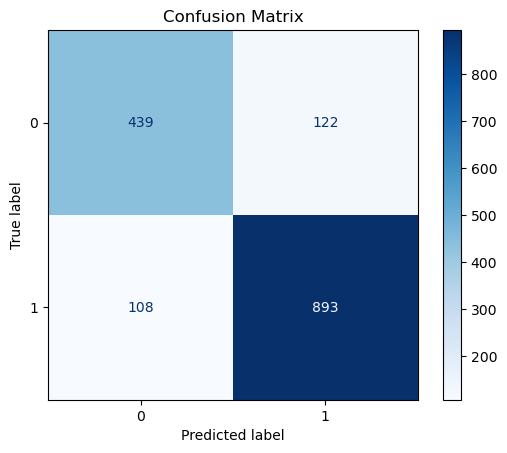

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(all_true, all_preds))

cm = confusion_matrix(all_true, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [37]:
df.head(1)

,SMILES,label
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,0


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42, stratify=labels)

In [39]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, f1_score, classification_report, confusion_matrix

In [40]:
lgbm_model = LGBMClassifier(random_state=42)

lgbm_model.fit(X_train, y_train)

y_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
y_pred_lgbm = (y_prob_lgbm >= 0.5).astype(int)

print(" LightGBM Results (Default Threshold = 0.5)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_prob_lgbm):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_lgbm):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgbm):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm, target_names=["-BBB", "+BBB"]))

[LightGBM] [Info] Number of positive: 3964, number of negative: 2281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 6245, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634748 -> initscore=0.552640
[LightGBM] [Info] Start training from score 0.552640
 LightGBM Results (Default Threshold = 0.5)
Accuracy: 0.8496
AUC: 0.9171
MCC: 0.6697
F1 Score: 0.8867
Confusion Matrix:
 [[407 163]
 [ 72 920]]

Classification Report:
               precision    recall  f1-score   support

        -BBB       0.85      0.71      0.78       570
        +BBB       0.85      0.93      0.89       992

    accuracy                           0.85      1562
   macro avg       0.85      0.82      0.83      1562
weighted avg       0.85      0.85      0.85      1562



C:\Users\vivek\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
